# 2023 데이터 크리에이터 캠프

## MISSION 1. AI-Hub 에서 데이터셋 다운로드 및 학습데이터와 테스트 데이터셋 만들기

### 1-1. 첨부된 그림의 경로에서 TS7, TS8.ZIP는 Training VS2.ZIP는 Test 데이터셋으로 압축을 풀어 이미지 폴더를 만든다.
### Training 과 Test 데이터의 이미지 수는 각각 얼마인가?

In [ ]:
import zipfile
import os
from concurrent.futures import ThreadPoolExecutor

trainZIP1 = 'TS7.zip'
trainZIP2 = 'TS8.zip'
testZIP = 'VS2.zip'
trainPath = 'train'
testPath = 'test'

if not os.path.exists(trainPath):
    os.makedirs(trainPath)

if not os.path.exists(testPath):
    os.makedirs(testPath)

def extract_zip(zipPath, targetPath): # 압축을 해제하는 함수
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall(targetPath)

with ThreadPoolExecutor(max_workers=3) as executor: # 쓰레딩으로 동시 압축 해제
    executor.submit(extract_zip, trainZIP1, trainPath)
    executor.submit(extract_zip, trainZIP2, trainPath)
    executor.submit(extract_zip, testZIP, testPath)

In [ ]:
import os

dataPaths = ['train', 'test']
datasetPath = os.getcwd()

for dataPath in dataPaths:
    folderPath = os.path.join(datasetPath, dataPath)
    imageExtensions = ['.jpg', '.png', '.jpeg']
    
    imageCount = 0
    
    for _, _, files in os.walk(folderPath):
        for file in files:
            if any(file.lower().endswith(ext) for ext in imageExtensions):
                imageCount += 1
    
    print(f"{folderPath} 폴더에 {imageCount}개의 이미지가 있음.")

    Output:
    D:\2023dcc\train 폴더에 129600개의 이미지가 있음.
    D:\2023dcc\test 폴더에 16200개의 이미지가 있음.

### 1-2. 이미지 이름에서 마지막 두자리가 01 : 마스크 미착용 02 : 마스크 부분 착용 03 : 마스크 착용을 의미한다.
### Training, Test에 각각 몇 개가 있는가?

In [ ]:
import os

suffixes = ['01', '02', '03']

imageExtensions = ['.jpg', '.jpeg', '.png']

dataPaths = ['train', 'test']
datasetPath = os.getcwd()

def countImage(dataPath):
    path = os.path.join(datasetPath, dataPath)
    imageCounts = {suffix: 0 for suffix in suffixes} # 라벨이 키인 딕셔너리를 정의
    for _, _, files in os.walk(path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in imageExtensions):
                try: # 파일 이름에서 라벨을 불러와 딕셔너리에 카운트
                    index = file.lower().split('.')[0].split('_')[-1]
                    imageCounts[index] += 1
                except: # 실패 시 파일명 반환
                    print(file)
                    exit(1)

    for suffix, count in imageCounts.items():
        print(f"{dataPath}에서 '{suffix}'로 끝나는 파일은 {count}개 있음.")

for dataPath in dataPaths:
    countImage(dataPath)

    Output:
    train에서 '01'로 끝나는 파일은 43200개 있음.
    train에서 '02'로 끝나는 파일은 43200개 있음.
    train에서 '03'로 끝나는 파일은 43200개 있음.
    test에서 '01'로 끝나는 파일은 5400개 있음.
    test에서 '02'로 끝나는 파일은 5400개 있음.
    test에서 '03'로 끝나는 파일은 5400개 있음.

## MISSION 2. 이미지 데이터 축소하기

### 2-1. 사진 크기가 너무 크기 때문에 사진을 축소해야 Colab에서 학습할 수 있을 것이다. 
### 어떤 크기로 이미지를 축소해야 하는지 결정하고, 실제 축소된 이미지 폴더를 만드시오.

In [ ]:
import os
import cv2

trainImagePath = 'train'
testImagePath = 'test'

trainResizedPath = 'train_resize'
testResizedPath = 'test_resize'

imageExtensions = ['.jpg', '.png', '.jpeg']

targetImageSize = (64, 64) # 이미지 사이즈

if not os.path.exists(trainResizedPath):
    os.makedirs(trainResizedPath)

if not os.path.exists(testResizedPath):
    os.makedirs(testResizedPath)

def resize(originalPath, resizedPath): # 원본 폴더에 있는 사진을 지정된 폴더에 리사이징하여 저장하는 함수
    for root, _, files in os.walk(originalPath):
        for filename in files:
            if any(filename.lower().endswith(ext) for ext in imageExtensions):
                imagePath = os.path.join(root, filename)

                relativePath = os.path.relpath(imagePath, originalPath)
                outputPath = os.path.join(resizedPath, relativePath) # 디렉토리 계산해서 저장 경로 지정

                os.makedirs(os.path.dirname(outputPath), exist_ok=True)
                
                img = cv2.imread(imagePath) # OpenCV로 이미지 읽어오기
                img = cv2.resize(img, targetImageSize, interpolation=cv2.INTER_AREA) # OpenCV로 이미지 리사이징
                cv2.imwrite(outputPath, img) # 이미지 저장

resize(trainImagePath, trainResizedPath)
resize(testImagePath, testResizedPath)

In [ ]:
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

trainResizedPath = 'train_resize'
testResizedPath = 'test_resize'

imageExtensions = ['.jpg', '.png', '.jpeg']


def datasetToNumpy(datasetPath, targetSize): # 이미지를 읽어와서 넘파이 배열로 변환하는 함수
    imageData = []
    labelData = []
    
    for root, _, files in os.walk(datasetPath):
        for filename in tqdm(files):
            if any(filename.lower().endswith(ext) for ext in imageExtensions):
                imgPath = os.path.join(root, filename)
                img = Image.open(imgPath)
                img = img.resize(targetSize)
                imgArray = np.array(img)
                
                index = filename.split('.')[0].split('_')[-1]
                
                imageData.append(imgArray)
                labelData.append(int(index))
    
    return np.array(imageData), np.array(labelData) # 이미지 데이터와 라벨 데이터를 각각의 넘파이 배열로 저장

# targetSize = (256, 256)
targetSize = (64, 64)

trainImages, trainLabels = datasetToNumpy(trainResizedPath, targetSize)
testImages, testLabels = datasetToNumpy(testResizedPath, targetSize)

# 변환된 넘파이 배열을 각각의 npy 파일로 저장
np.save('train_images.npy', trainImages)
np.save('train_labels.npy', trainLabels)
np.save('test_images.npy', testImages)
np.save('test_labels.npy', testLabels)

### 2-2. 이미지 파일을 Colab으로 옮기는 것은 여러가지로 어렵다. 두가지 방식을 사용할 수 있다. 적절한 방법을 택해서 수행하시오.

(1) 로컬 컴퓨터에서 이미지를 넘파이 배열로 만들어 Colab으로 전송하는 방법 

(2) 이미지를 하나의 압축파일로 만들어 Colab으로 전송하는 방법

2-1에서 1번 방법을 사용하여, numpy 배열로 변환 후 파일로 저장.

## MISSION 3

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset, ConcatDataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch.nn.functional as F
from datetime import datetime
from torchvision.utils import make_grid
from tqdm import tqdm
import wandb
import os

In [2]:
wandb.init(project="23-dcc", name = 'CenterCrop (50 -> 32), Conv3, Do1(0.15)')

wandb.run.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: woosuknam (asseertive). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [3]:
# 저장된 넘파이 배열 불러오기
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')

In [4]:
# 레이블 수정: 1번 레이블을 0(마스크 미착용), 2/3번 레이블을 1(마스크 착용)로 변경
train_labels[train_labels == 1] = 0
train_labels[train_labels == 2] = 1
train_labels[train_labels == 3] = 1

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# 데이터 증강을 위한 변환 정의
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((50,50)),
    transforms.Resize((32,32))
])

# 데이터셋 정의
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, select_label=None, limit=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.select_label = select_label
        self.limit = limit

    def __len__(self):
        if self.limit is not None:
            return self.limit
            
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.select_label is not None and label != self.select_label:
            return self.__getitem__(idx + 1)

        if self.transform:
            image = self.transform(TF.to_pil_image(image))
            image = TF.to_tensor(image)
        else:
            image = TF.to_tensor(image)

        return image, label

# original_dataset = CustomDataset(train_images, train_labels)
augmented_dataset = CustomDataset(train_images, train_labels, transform)
nomask_added_dataset = CustomDataset(train_images, train_labels, transform, select_label=0, limit=(sum(1 for label in train_labels if label == 1) - sum(1 for label in train_labels if label == 0)))

dataset = ConcatDataset([augmented_dataset, nomask_added_dataset])

In [7]:
# 데이터를 train과 validation 세트로 나누기
train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 데이터로더 설정
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

100%|█████████████████████████████████████████████████████████████████████████| 172800/172800 [00:18<00:00, 9440.70it/s]


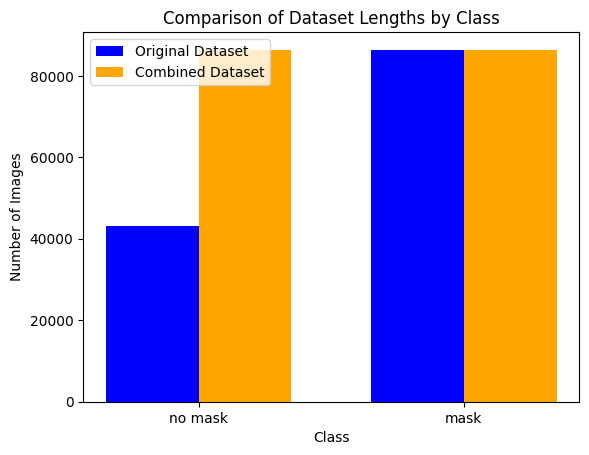

In [8]:
original_class_count = [0, 0]
combined_class_count = [0, 0]

for label in tqdm(train_labels):
    if label == 0:
        original_class_count[0] += 1
    if label == 1:
        original_class_count[1] += 1

for _, label in tqdm(dataset):
    if label == 0:
        combined_class_count[0] += 1
    if label == 1:
        combined_class_count[1] += 1

# 시각화
labels = ['no mask', 'mask']
original_counts = [original_class_count[0], original_class_count[1]]
combined_counts = [combined_class_count[0], combined_class_count[1]]

bar_width = 0.35
index = range(len(labels))

plt.bar(index, original_counts, bar_width, label='Original Dataset', color='blue')
plt.bar([i + bar_width for i in index], combined_counts, bar_width, label='Combined Dataset', color='orange')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Comparison of Dataset Lengths by Class')
plt.xticks([i + bar_width / 2 for i in index], labels)
plt.legend()
plt.show()
# plt.savefig('comparison-of-dataset.png', dpi=200)

In [9]:
# 이진 분류 모델 정의
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.15)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(2048, 128)
        self.relu4 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 256)
        self.relu5 = nn.ReLU()
        
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

model = CustomClassifier()
model.to(device)

CustomClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.15, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (relu5): ReLU()
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

    Output:
    CustomClassifier(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu1): ReLU()
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout1): Dropout(p=0.15, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (relu2): ReLU()
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (relu3): ReLU()
      (fc1): Linear(in_features=2048, out_features=128, bias=True)
      (relu4): ReLU()
      (fc2): Linear(in_features=128, out_features=256, bias=True)
      (relu5): ReLU()
      (fc3): Linear(in_features=256, out_features=1, bias=True)
      (sigmoid): Sigmoid()
    )

In [10]:
# Hyperparameters
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

wandb.watch(model, criterion, log="all")

[]

In [11]:
# Define training and validation functions
def train(model, train_loader, epoch):
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"epoch {epoch}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view_as(outputs).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(train_loader)

In [12]:
def validate(model, valid_loader):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view_as(outputs).float())
            valid_loss += loss.item()
            predicted = (outputs > 0.5).squeeze()
            total += labels.size(0)
            correct += (predicted == labels.byte()).sum().item()

    accuracy = 100 * correct / total
    return valid_loss / len(valid_loader), accuracy

In [13]:
train_losses = []
valid_losses = []

epochs = 100

wandb.config.update({
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size
})

for epoch in range(epochs):
    wandb.config.update({
        "epoch": epoch
    })
    
    train_loss = train(model, train_loader, epoch)
    valid_loss, valid_accuracy = validate(model, valid_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    wandb.log({"train": {"loss": train_loss}, "val": {"loss": valid_loss, "acc": valid_accuracy}}, step=epoch)

    print(f"Epoch {epoch + 1}/{epochs}:")
    print(f"  Training Loss: {train_loss:.4f}")
    print(f"  Validation Loss: {valid_loss:.4f}")
    print(f"  Validation Accuracy: {valid_accuracy:.2f}%")

now = datetime.now()

if os.path.exists('./weights') == False:
    os.mkdir('./weights')

torch.save(model.state_dict(), f'./weights/{now.strftime("%Y-%m-%d_%H:%M:%S")}.pth')
wandb.finish()

100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.38it/s]


Epoch 1/100:
  Training Loss: 0.1089
  Validation Loss: 0.0507
  Validation Accuracy: 98.35%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.38it/s]


Epoch 2/100:
  Training Loss: 0.0449
  Validation Loss: 0.0332
  Validation Accuracy: 99.00%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.35it/s]


Epoch 3/100:
  Training Loss: 0.0361
  Validation Loss: 0.0324
  Validation Accuracy: 99.07%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.99it/s]


Epoch 4/100:
  Training Loss: 0.0306
  Validation Loss: 0.0385
  Validation Accuracy: 98.69%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.97it/s]


Epoch 5/100:
  Training Loss: 0.0270
  Validation Loss: 0.0280
  Validation Accuracy: 99.05%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.18it/s]


Epoch 6/100:
  Training Loss: 0.0254
  Validation Loss: 0.0232
  Validation Accuracy: 99.31%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.63it/s]


Epoch 7/100:
  Training Loss: 0.0226
  Validation Loss: 0.0217
  Validation Accuracy: 99.26%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.07it/s]


Epoch 8/100:
  Training Loss: 0.0207
  Validation Loss: 0.0182
  Validation Accuracy: 99.35%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.52it/s]


Epoch 9/100:
  Training Loss: 0.0192
  Validation Loss: 0.0186
  Validation Accuracy: 99.40%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.96it/s]


Epoch 10/100:
  Training Loss: 0.0173
  Validation Loss: 0.0179
  Validation Accuracy: 99.37%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.84it/s]


Epoch 11/100:
  Training Loss: 0.0171
  Validation Loss: 0.0178
  Validation Accuracy: 99.47%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.18it/s]


Epoch 12/100:
  Training Loss: 0.0153
  Validation Loss: 0.0190
  Validation Accuracy: 99.34%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.77it/s]


Epoch 13/100:
  Training Loss: 0.0151
  Validation Loss: 0.0127
  Validation Accuracy: 99.59%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.03it/s]


Epoch 14/100:
  Training Loss: 0.0152
  Validation Loss: 0.0118
  Validation Accuracy: 99.59%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.73it/s]


Epoch 15/100:
  Training Loss: 0.0135
  Validation Loss: 0.0145
  Validation Accuracy: 99.53%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.85it/s]


Epoch 16/100:
  Training Loss: 0.0135
  Validation Loss: 0.0153
  Validation Accuracy: 99.47%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.01it/s]


Epoch 17/100:
  Training Loss: 0.0125
  Validation Loss: 0.0150
  Validation Accuracy: 99.50%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.49it/s]


Epoch 18/100:
  Training Loss: 0.0127
  Validation Loss: 0.0110
  Validation Accuracy: 99.63%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.51it/s]


Epoch 19/100:
  Training Loss: 0.0116
  Validation Loss: 0.0123
  Validation Accuracy: 99.61%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.61it/s]


Epoch 20/100:
  Training Loss: 0.0114
  Validation Loss: 0.0134
  Validation Accuracy: 99.57%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.74it/s]


Epoch 21/100:
  Training Loss: 0.0115
  Validation Loss: 0.0135
  Validation Accuracy: 99.53%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.41it/s]


Epoch 22/100:
  Training Loss: 0.0100
  Validation Loss: 0.0106
  Validation Accuracy: 99.67%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.30it/s]


Epoch 23/100:
  Training Loss: 0.0112
  Validation Loss: 0.0117
  Validation Accuracy: 99.63%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.36it/s]


Epoch 24/100:
  Training Loss: 0.0122
  Validation Loss: 0.0138
  Validation Accuracy: 99.61%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.65it/s]


Epoch 25/100:
  Training Loss: 0.0110
  Validation Loss: 0.0087
  Validation Accuracy: 99.73%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.77it/s]


Epoch 26/100:
  Training Loss: 0.0090
  Validation Loss: 0.0135
  Validation Accuracy: 99.69%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.76it/s]


Epoch 27/100:
  Training Loss: 0.0110
  Validation Loss: 0.0226
  Validation Accuracy: 99.39%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.76it/s]


Epoch 28/100:
  Training Loss: 0.0092
  Validation Loss: 0.0136
  Validation Accuracy: 99.60%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.71it/s]


Epoch 29/100:
  Training Loss: 0.0095
  Validation Loss: 0.0106
  Validation Accuracy: 99.69%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.62it/s]


Epoch 30/100:
  Training Loss: 0.0090
  Validation Loss: 0.0111
  Validation Accuracy: 99.63%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.22it/s]


Epoch 31/100:
  Training Loss: 0.0082
  Validation Loss: 0.0146
  Validation Accuracy: 99.59%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.42it/s]


Epoch 32/100:
  Training Loss: 0.0089
  Validation Loss: 0.0093
  Validation Accuracy: 99.70%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.92it/s]


Epoch 33/100:
  Training Loss: 0.0089
  Validation Loss: 0.0140
  Validation Accuracy: 99.68%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.88it/s]


Epoch 34/100:
  Training Loss: 0.0082
  Validation Loss: 0.0083
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.75it/s]


Epoch 35/100:
  Training Loss: 0.0086
  Validation Loss: 0.0185
  Validation Accuracy: 99.50%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.38it/s]


Epoch 36/100:
  Training Loss: 0.0080
  Validation Loss: 0.0093
  Validation Accuracy: 99.70%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.60it/s]


Epoch 37/100:
  Training Loss: 0.0084
  Validation Loss: 0.0089
  Validation Accuracy: 99.75%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.87it/s]


Epoch 38/100:
  Training Loss: 0.0077
  Validation Loss: 0.0092
  Validation Accuracy: 99.73%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.27it/s]


Epoch 39/100:
  Training Loss: 0.0072
  Validation Loss: 0.0132
  Validation Accuracy: 99.60%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.83it/s]


Epoch 40/100:
  Training Loss: 0.0084
  Validation Loss: 0.0123
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.64it/s]


Epoch 41/100:
  Training Loss: 0.0092
  Validation Loss: 0.0101
  Validation Accuracy: 99.71%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.84it/s]


Epoch 42/100:
  Training Loss: 0.0069
  Validation Loss: 0.0107
  Validation Accuracy: 99.73%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.13it/s]


Epoch 43/100:
  Training Loss: 0.0080
  Validation Loss: 0.0108
  Validation Accuracy: 99.75%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.97it/s]


Epoch 44/100:
  Training Loss: 0.0074
  Validation Loss: 0.0095
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.85it/s]


Epoch 45/100:
  Training Loss: 0.0083
  Validation Loss: 0.0093
  Validation Accuracy: 99.75%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.96it/s]


Epoch 46/100:
  Training Loss: 0.0084
  Validation Loss: 0.0150
  Validation Accuracy: 99.68%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.87it/s]


Epoch 47/100:
  Training Loss: 0.0068
  Validation Loss: 0.0111
  Validation Accuracy: 99.71%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.38it/s]


Epoch 48/100:
  Training Loss: 0.0075
  Validation Loss: 0.0098
  Validation Accuracy: 99.70%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.89it/s]


Epoch 49/100:
  Training Loss: 0.0071
  Validation Loss: 0.0103
  Validation Accuracy: 99.71%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.57it/s]


Epoch 50/100:
  Training Loss: 0.0078
  Validation Loss: 0.0135
  Validation Accuracy: 99.74%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.02it/s]


Epoch 51/100:
  Training Loss: 0.0075
  Validation Loss: 0.0098
  Validation Accuracy: 99.74%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.76it/s]


Epoch 52/100:
  Training Loss: 0.0065
  Validation Loss: 0.0096
  Validation Accuracy: 99.79%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.72it/s]


Epoch 53/100:
  Training Loss: 0.0080
  Validation Loss: 0.0168
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.07it/s]


Epoch 54/100:
  Training Loss: 0.0091
  Validation Loss: 0.0087
  Validation Accuracy: 99.73%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.88it/s]


Epoch 55/100:
  Training Loss: 0.0069
  Validation Loss: 0.0138
  Validation Accuracy: 99.70%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.51it/s]


Epoch 56/100:
  Training Loss: 0.0073
  Validation Loss: 0.0145
  Validation Accuracy: 99.67%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.16it/s]


Epoch 57/100:
  Training Loss: 0.0069
  Validation Loss: 0.0122
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.64it/s]


Epoch 58/100:
  Training Loss: 0.0078
  Validation Loss: 0.0266
  Validation Accuracy: 99.65%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.18it/s]


Epoch 59/100:
  Training Loss: 0.0120
  Validation Loss: 0.0095
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.84it/s]


Epoch 60/100:
  Training Loss: 0.0076
  Validation Loss: 0.0125
  Validation Accuracy: 99.75%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.96it/s]


Epoch 61/100:
  Training Loss: 0.0073
  Validation Loss: 0.0145
  Validation Accuracy: 99.75%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.53it/s]


Epoch 62/100:
  Training Loss: 0.0077
  Validation Loss: 0.0166
  Validation Accuracy: 99.61%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.69it/s]


Epoch 63/100:
  Training Loss: 0.0074
  Validation Loss: 0.0100
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.72it/s]


Epoch 64/100:
  Training Loss: 0.0080
  Validation Loss: 0.0097
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.25it/s]


Epoch 65/100:
  Training Loss: 0.0068
  Validation Loss: 0.0152
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.93it/s]


Epoch 66/100:
  Training Loss: 0.0070
  Validation Loss: 0.0100
  Validation Accuracy: 99.79%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.82it/s]


Epoch 67/100:
  Training Loss: 0.0067
  Validation Loss: 0.0147
  Validation Accuracy: 99.71%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.59it/s]


Epoch 68/100:
  Training Loss: 0.0059
  Validation Loss: 0.0200
  Validation Accuracy: 99.59%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.42it/s]


Epoch 69/100:
  Training Loss: 0.0069
  Validation Loss: 0.0095
  Validation Accuracy: 99.80%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.60it/s]


Epoch 70/100:
  Training Loss: 0.0090
  Validation Loss: 0.0170
  Validation Accuracy: 99.67%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.56it/s]


Epoch 71/100:
  Training Loss: 0.0054
  Validation Loss: 0.0089
  Validation Accuracy: 99.77%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.46it/s]


Epoch 72/100:
  Training Loss: 0.0068
  Validation Loss: 0.0096
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.49it/s]


Epoch 73/100:
  Training Loss: 0.0069
  Validation Loss: 0.0109
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.85it/s]


Epoch 74/100:
  Training Loss: 0.0068
  Validation Loss: 0.0123
  Validation Accuracy: 99.77%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.84it/s]


Epoch 75/100:
  Training Loss: 0.0060
  Validation Loss: 0.0141
  Validation Accuracy: 99.66%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.29it/s]


Epoch 76/100:
  Training Loss: 0.0065
  Validation Loss: 0.0073
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.46it/s]


Epoch 77/100:
  Training Loss: 0.0057
  Validation Loss: 0.0108
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.73it/s]


Epoch 78/100:
  Training Loss: 0.0079
  Validation Loss: 0.0123
  Validation Accuracy: 99.74%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.23it/s]


Epoch 79/100:
  Training Loss: 0.0056
  Validation Loss: 0.0118
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.01it/s]


Epoch 80/100:
  Training Loss: 0.0064
  Validation Loss: 0.0087
  Validation Accuracy: 99.81%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.91it/s]


Epoch 81/100:
  Training Loss: 0.0064
  Validation Loss: 0.0195
  Validation Accuracy: 99.65%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.97it/s]


Epoch 82/100:
  Training Loss: 0.0061
  Validation Loss: 0.0129
  Validation Accuracy: 99.77%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.49it/s]


Epoch 83/100:
  Training Loss: 0.0081
  Validation Loss: 0.0104
  Validation Accuracy: 99.74%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.70it/s]


Epoch 84/100:
  Training Loss: 0.0062
  Validation Loss: 0.0146
  Validation Accuracy: 99.79%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.42it/s]


Epoch 85/100:
  Training Loss: 0.0075
  Validation Loss: 0.0199
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.68it/s]


Epoch 86/100:
  Training Loss: 0.0078
  Validation Loss: 0.0123
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.61it/s]


Epoch 87/100:
  Training Loss: 0.0059
  Validation Loss: 0.0113
  Validation Accuracy: 99.72%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.15it/s]


Epoch 88/100:
  Training Loss: 0.0068
  Validation Loss: 0.0077
  Validation Accuracy: 99.78%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.74it/s]


Epoch 89/100:
  Training Loss: 0.0067
  Validation Loss: 0.0128
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.52it/s]


Epoch 90/100:
  Training Loss: 0.0064
  Validation Loss: 0.0091
  Validation Accuracy: 99.83%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.05it/s]


Epoch 91/100:
  Training Loss: 0.0084
  Validation Loss: 0.0159
  Validation Accuracy: 99.47%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.99it/s]


Epoch 92/100:
  Training Loss: 0.0089
  Validation Loss: 0.0123
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.74it/s]


Epoch 93/100:
  Training Loss: 0.0081
  Validation Loss: 0.0120
  Validation Accuracy: 99.76%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.48it/s]


Epoch 94/100:
  Training Loss: 0.0058
  Validation Loss: 0.0075
  Validation Accuracy: 99.77%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.12it/s]


Epoch 95/100:
  Training Loss: 0.0068
  Validation Loss: 0.0140
  Validation Accuracy: 99.77%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.65it/s]


Epoch 96/100:
  Training Loss: 0.0057
  Validation Loss: 0.0260
  Validation Accuracy: 99.35%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.86it/s]


Epoch 97/100:
  Training Loss: 0.0063
  Validation Loss: 0.0087
  Validation Accuracy: 99.82%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.80it/s]


Epoch 98/100:
  Training Loss: 0.0042
  Validation Loss: 0.0089
  Validation Accuracy: 99.82%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 136.15it/s]


Epoch 99/100:
  Training Loss: 0.0059
  Validation Loss: 0.0112
  Validation Accuracy: 99.65%


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [00:05<00:00, 137.00it/s]

Epoch 100/100:
  Training Loss: 0.0062
  Validation Loss: 0.0091
  Validation Accuracy: 99.72%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


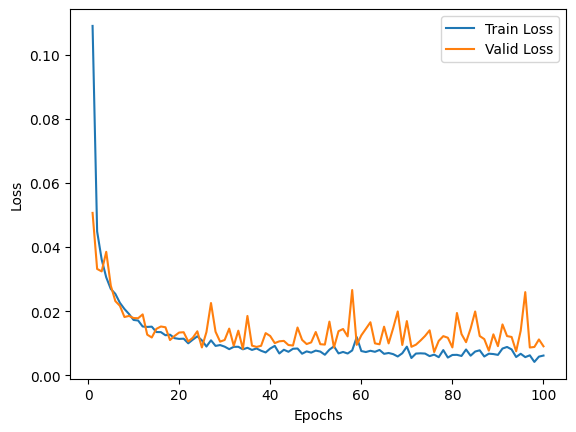

In [14]:
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# 저장된 테스트 넘파이 배열 불러오기
test_images = np.load('test_images.npy')
test_labels = np.load('test_labels.npy')

# 레이블 수정: 1번 레이블을 0(마스크 미착용), 2/3번 레이블을 1(마스크 착용)로 변경
test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 1
test_labels[test_labels == 3] = 1

test_images = torch.from_numpy(test_images).permute(0, 3, 1, 2)
test_labels = torch.from_numpy(test_labels)

test_dataset = TensorDataset(test_images, test_labels)

batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

tensor([[0.7311]])
tensor([[0.7311]])
tensor([[0.7311]])
tensor([[0.5000]])
tensor([[0.5000]])
tensor([[0.5000]])
tensor([[0.5000]])
tensor([[0.7311]])
tensor([[0.7311]])
tensor([[0.7311]])


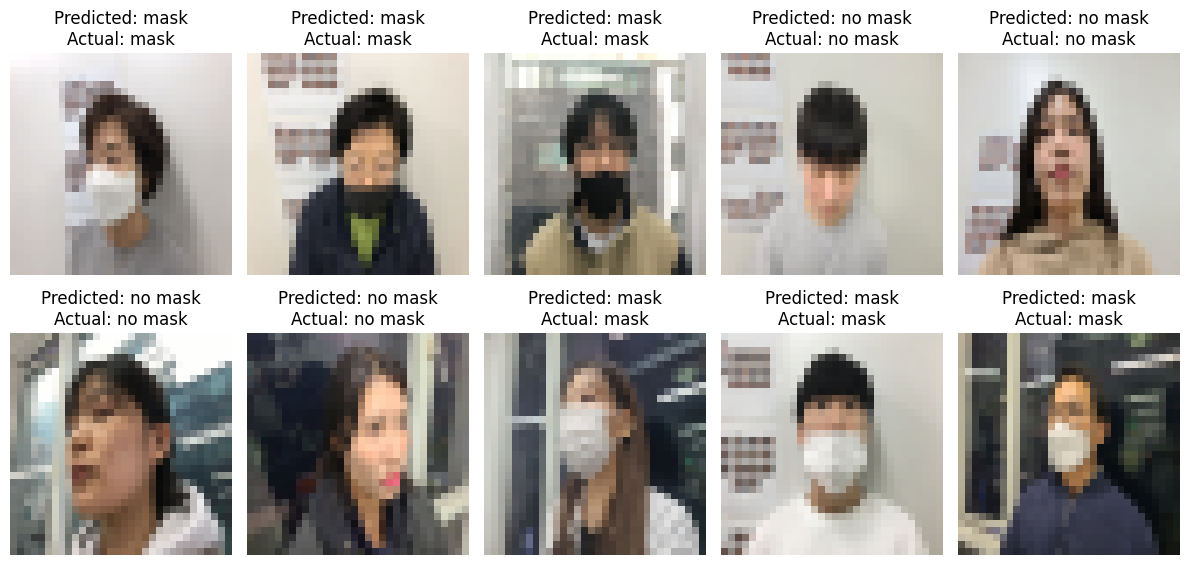

In [18]:
# 추론 시각화
# 데이터셋을 이터레이터로 변환
data_iterator = iter(test_loader)

model.to('cpu')

classes = ['no mask', 'mask']

plt.figure(figsize=(12, 6))
for i in range(10):
    try:
        image, label = next(data_iterator)
        image = transforms.Resize((32, 32))(image)

        with torch.no_grad():
            outputs = model(image.to(torch.float))

        probabilities = torch.sigmoid(outputs)

        print(probabilities)
        predicted_class = torch.round(probabilities).squeeze().int().item()
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(image[0].permute(1, 2, 0) / 255.0)
        plt.title(f'Predicted: {classes[predicted_class]}\nActual: {classes[int(label.item())]}')
        plt.axis('off')
    except StopIteration:
        break

plt.tight_layout()
plt.show()

### 3-1. 마스크 착용여부 이진 분류를 수행하여 Test 데이터의 F1 Score를 제시하시오.

(이 때 턱스크는 착용으로 간주)

In [19]:
from sklearn.metrics import classification_report, f1_score

model = CustomClassifier()
model.load_state_dict(torch.load(f'./weights/{now.strftime("%Y-%m-%d_%H:%M:%S")}.pth'))

def get_predictions(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = transforms.Resize((32, 32))(inputs)
            outputs = model(inputs.to(torch.float))
            predicted_labels = (torch.sigmoid(outputs) > 0.5).int()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

predictions, labels = get_predictions(model, test_loader)
report = classification_report(labels, predictions, target_names=classes)
print(report)
print(f"F1 Score: {f1_score(labels, predictions):.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


              precision    recall  f1-score   support

     no mask       0.89      0.95      0.92      5400
        mask       0.97      0.94      0.96     10800

    accuracy                           0.94     16200
   macro avg       0.93      0.95      0.94     16200
weighted avg       0.95      0.94      0.94     16200

F1 Score: 0.9570


    Output:
    /usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
      warnings.warn(

                  precision    recall  f1-score   support

        no mask       0.89      0.95      0.92      5400
           mask       0.97      0.94      0.96     10800

    accuracy                              0.94     16200
    macro avg         0.93      0.95      0.94     16200
    weighted avg      0.95      0.94      0.94     16200

    F1 Score: 0.9570


### 3-2. 클래스 불균형 문제를 해결하고 Accuracy와 Precision, Recall, F1 Score를 계산해본 뒤 3-1.과 비교하세요.

    클래스 불균형 해결 전:
    Accuracy: 0.9183
    Precision: 0.9787
    Recall: 0.8970
    F1 Score: 0.9361

    클래스 불균형 해결 후:
    Accuracy: 0.9421
    Precision: 0.9810
    Recall: 0.9312
    F1 Score: 0.9554

### 3-3. 모형의 인식 성능을 올리는 작업을 수행하고 작업 수행과정을 설명하시오. 어떤 수행을 했고, 정확도는 어떻게 변했는가? 왜 그런 결과가 나왔는가?

1. 하이퍼파라미터 조정
    - 이동 평균을 사용하여 학습률을 동적으로 조정할 수 있도록 Adam 학습 알고리즘(옵티마이저)를 사용했습니다.
    - 가중치가 업데이트되는 주기인 Learning Rate를 조절하여 파라미터가 일반화되게 할 수 있도록 했습니다.
    - 연산 부하를 줄이기 위해 이미지 배치 사이즈를 조절하여 Loss Function을 효율적으로 최적화했습니다.

<br />

2. 모델 아키텍처 개선
    - 레이어의 구조와 크기, 컨볼루션 필터 수, 히든 레이어 유닛 수 등을 조정하여 정교한 모델을 제작했습니다.

### 3-4. 오류가 나온 이미지에 대해 왜 오류가 나왔는지 그동안 미션 수행에서 얻은 경험과 지식을 통해 설명하시오.

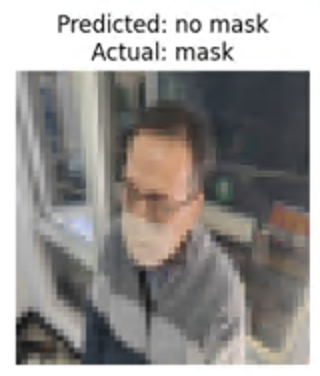

사람의 눈으로 봐도 구분하기 힘들었던 예시입니다.

마스크와 피부 색이 비슷하여 모델도 특징점을 찾아낵 힘들었던 것 같다고 생각합니다.

이러한 부분을 조금이라도 개선하기 위하여 모델이 얼굴에서만 특징점을 찾아내도록 이미지의 중앙을 확대하는 CenterCrop을 진행했습니다.